# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

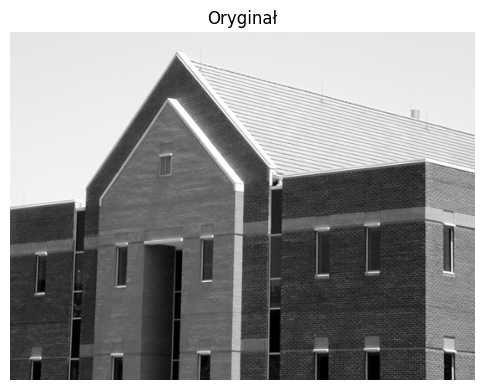

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import requests

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/'

fileNames = ["dom.png"]
for fileName in fileNames:
    if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

def plots(**kwargs):

    n = len(kwargs)
    fig, axes = plt.subplots(((n - 1) // 3) + 1, np.min([3, n]))
    fig.set_size_inches(np.min([n * 6, 20]), (((n - 1) // 3) + 1) * 8)
    i = 0

    for key, image in kwargs.items():
        if n == 1:
            axes.imshow(image, "gray")
            axes.axis("off")
            axes.set_title(key)
            axes.set_facecolor('white')
        elif n <= 3:
            axes[i].imshow(image, "gray")
            axes[i].axis("off")
            axes[i].set_title(key)
            axes[i].set_facecolor('white')
        elif n > 3:
            axes[i // 3, i % 3].imshow(image, "gray")
            axes[i // 3, i % 3].set_title(key)
            axes[i // 3, i % 3].set_facecolor('white')

        i += 1

    if n > 1:
        for ax in axes.flat:
            ax.axis("off")

    fig.patch.set_facecolor('white')

    plt.show()

dom = cv2.imread("dom.png", cv2.IMREAD_GRAYSCALE)

images = {
    "Oryginał": dom
}

plots(**images)

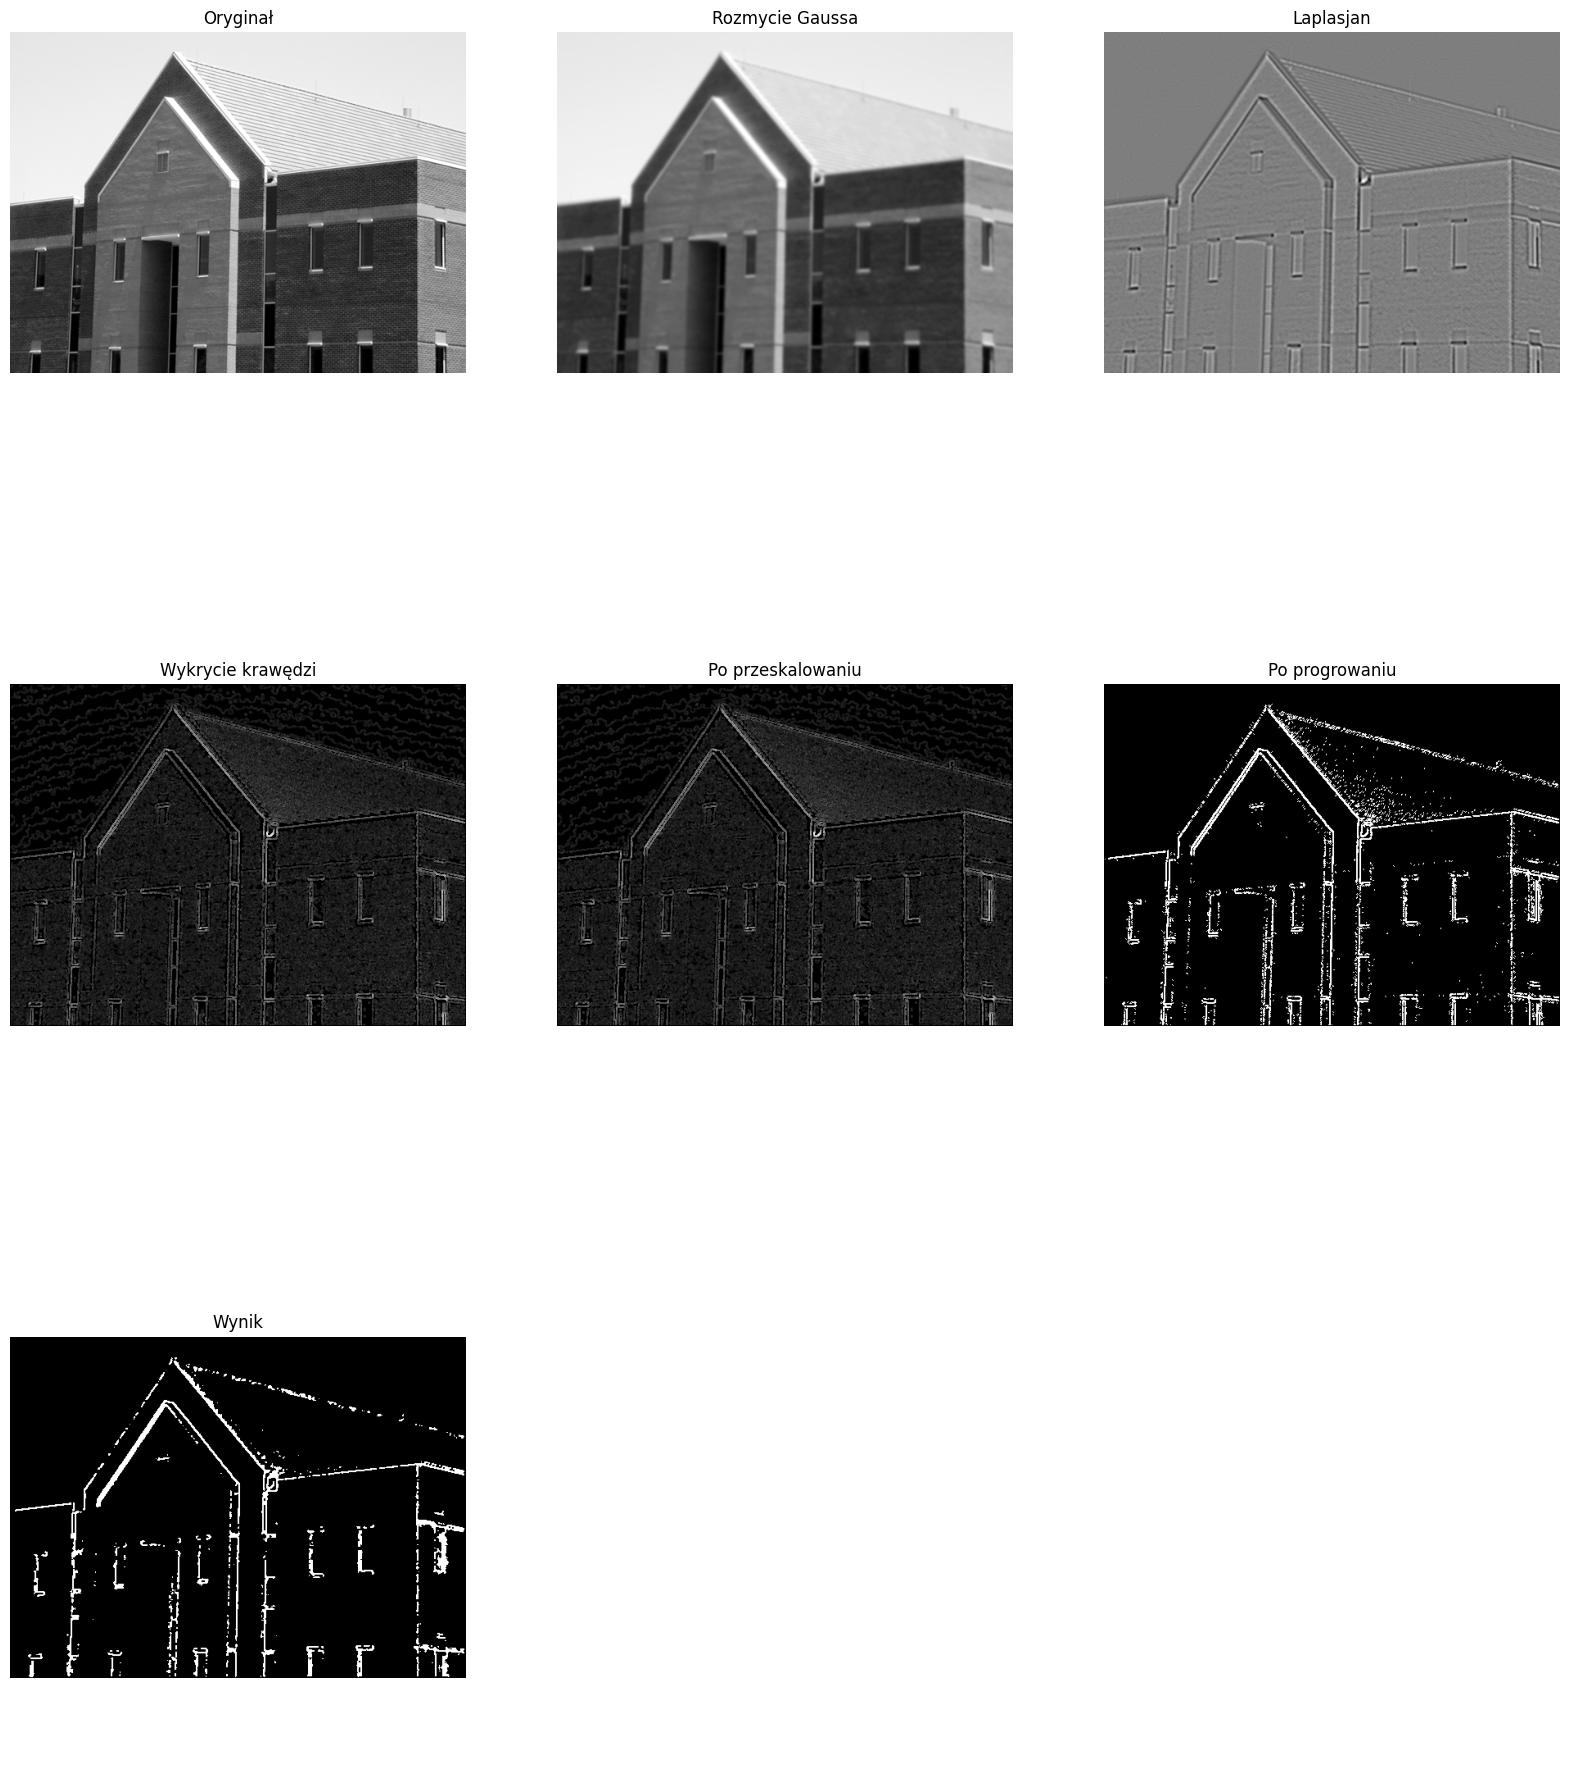

In [3]:
gauss_blur = cv2.GaussianBlur(dom, (7, 7), 1.6)
laplacian = cv2.Laplacian(gauss_blur, cv2.CV_32F)

images = {
    "Oryginał": dom,
    "Rozmycie Gaussa": gauss_blur,
    "Laplasjan": laplacian
}

def get_neighbours(img: np.ndarray, i, j, size):
    n = size // 2
    height, width = img.shape

    if n <= i and n <= j and i + n <= height - 1 and j + n <= width - 1:
        img_part = np.copy(img[i - n : i + n + 1, j - n : j + n + 1])
        return img_part
    else:
        print("Couldn't get neighbourhood proper")
        return None

def get_min_max(img_part: np.ndarray):
    return np.min(img_part), np.max(img_part)

def is_different_sign(min, max):
    return (not (min >= 0 and max >= 0)) and (not (min < 0 and max < 0))

def is_border(img: np.ndarray, i, j, neigh_size=3):
    neighbourhood = get_neighbours(img, i, j, neigh_size)
    pixel = img[i, j]
    min, max = get_min_max(neighbourhood)

    if is_different_sign(min, max):
        if pixel >= 0:
            return pixel + np.abs(min)
        else:
            return np.abs(pixel) + max
    else:
        return 0

def scale_img(img: np.ndarray):
    height, width = img.shape
    min, max = get_min_max(img)
    pre_scale_range = max - min

    for i in range(height):
        for j in range(width):
            img[i, j] = 255 * (img[i, j] - min) / pre_scale_range

def crossing(log: np.ndarray, thr):
    height, width = log.shape
    results = np.zeros((height, width))

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            results[i, j] = is_border(log, i, j)

    images["Wykrycie krawędzi"] = results

    scale_img(results)
    images["Po przeskalowaniu"] = results

    results = results > thr
    images["Po progrowaniu"] = results

    return cv2.medianBlur(results.astype(np.uint8), 3)

images["Wynik"] = crossing(laplacian, 65)
plots(**images)

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w 1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną).
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

In [14]:
def get_amplitude_and_angles(laplacian: np.ndarray):
    sobel_vertical = cv2.Sobel(laplacian, cv2.CV_64F, 1, 0, ksize=3)
    sobel_horizontal = cv2.Sobel(laplacian, cv2.CV_64F, 0, 1, ksize=3)

    amplitude = np.square(np.power(sobel_horizontal, 2) + np.power(sobel_vertical, 2))
    angle = np.arctan2(sobel_horizontal, sobel_vertical)

    return amplitude, angle

def quantize_angles(angle: np.ndarray):
    directions = [i % 4 for i in range(8)]
    divided_on_eight = np.round(angle / (np.pi / 4)).astype(np.int8)

    return directions[divided_on_eight]

def analyze_directions(img_part: np.ndarray, direction):
    if img_part.shape == (3, 3):
        central_pixel = img_part[1, 1]
        match direction:
            case 0:
                if img_part[1, 0] > central_pixel  or img_part[1, 2] > central_pixel:
                    return 0
                return central_pixel
            case 1:
                if img_part[0, 0] > central_pixel  or img_part[2, 2] > central_pixel:
                    return 0
                return central_pixel
            case 2:
                if img_part[0, 0] > central_pixel  or img_part[2, 2] > central_pixel:
                    return 0
                return central_pixel
            case 3:
                if img_part[0, 0] > central_pixel  or img_part[2, 2] > central_pixel:
                    return 0
                return central_pixel

    print("Not adjusted for img_part shape other than (3, 3)")
    return None

def nonmax(directions: np.ndarray, amplitude: np.ndarray):
    height, width = directions.shape
    gN = np.zeros(directions.shape)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            gN = analyze_directions(get_neighbours(amplitude, i, j, 3), directions[i, j])

    return gN

def canny_binarization(gN: np.ndarray, tl, th):
    height, width = gN.shape

    gNH = gN >= th
    gNL = th > gN > tl

    visited = np.zeros(gN.shape)
    results = np.zeros(gN.shape)
    stack = [[i, j] for i in range(height) for j in range(width)]

    while len(stack) > 0:
        i, j = stack.pop()

        if not visited[i, j]:
            visited[i, j] = 1
            results[i, j] = 255



    return stack

def canny_detection(img: np.ndarray, tl, th):

    gauss_blur = cv2.GaussianBlur(img, (3, 3), 0)
    laplacian = cv2.Laplacian(gauss_blur, cv2.CV_32F)

    amplitude, angle = get_amplitude_and_angles(laplacian)

    directions = quantize_angles(angle)

    gN = nonmax(directions, amplitude)

    return canny_binarization(gN, tl, th)

# canny_detection(dom)
canny_binarization(np.zeros(dom.shape), 1, 2)


[416, 556]
0.0


[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9],
 [0, 10],
 [0, 11],
 [0, 12],
 [0, 13],
 [0, 14],
 [0, 15],
 [0, 16],
 [0, 17],
 [0, 18],
 [0, 19],
 [0, 20],
 [0, 21],
 [0, 22],
 [0, 23],
 [0, 24],
 [0, 25],
 [0, 26],
 [0, 27],
 [0, 28],
 [0, 29],
 [0, 30],
 [0, 31],
 [0, 32],
 [0, 33],
 [0, 34],
 [0, 35],
 [0, 36],
 [0, 37],
 [0, 38],
 [0, 39],
 [0, 40],
 [0, 41],
 [0, 42],
 [0, 43],
 [0, 44],
 [0, 45],
 [0, 46],
 [0, 47],
 [0, 48],
 [0, 49],
 [0, 50],
 [0, 51],
 [0, 52],
 [0, 53],
 [0, 54],
 [0, 55],
 [0, 56],
 [0, 57],
 [0, 58],
 [0, 59],
 [0, 60],
 [0, 61],
 [0, 62],
 [0, 63],
 [0, 64],
 [0, 65],
 [0, 66],
 [0, 67],
 [0, 68],
 [0, 69],
 [0, 70],
 [0, 71],
 [0, 72],
 [0, 73],
 [0, 74],
 [0, 75],
 [0, 76],
 [0, 77],
 [0, 78],
 [0, 79],
 [0, 80],
 [0, 81],
 [0, 82],
 [0, 83],
 [0, 84],
 [0, 85],
 [0, 86],
 [0, 87],
 [0, 88],
 [0, 89],
 [0, 90],
 [0, 91],
 [0, 92],
 [0, 93],
 [0, 94],
 [0, 95],
 [0, 96],
 [0, 97],
 [0, 98],
 [0, 99],
 [0, 100],

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.